## Desafio: Leitura de códigos de barras
Diversas características das cenas e dos sistemas ópticos podem levar a mudança na morfologia de um código de barras. Transformações como distorção pela perspectiva e rotação pelo posicionamento do item são os efeitos mais recorrentes. Como, em um código de barras a informação está armazenada nas espessuras das barras e distâncias entre elas essas deformações podem levar a leituras equivocadas.
No seu sistema você utiliza uma câmera, para avaliar as formas e tamanhos de produtos que passam por uma esteira, como no exemplo anterior. Porém, agora também é necessário que o código de barras de cada item seja lido.

Se a sua câmera funciona de maneira fixa, que não é possível adaptá-lo para cada ângulo de inclinação que os códigos de barras se apresentam, e assim compensar as distorções, proponha em conjunto com a turma uma maneira de fazer com que seu sistema seja capaz de identificar os códigos de barras.

### Código de barras
Em um código de barras a informação está armazenada nas espessuras das barras e distâncias entre elas.

<class 'numpy.ndarray'>
(232, 464, 4) uint8


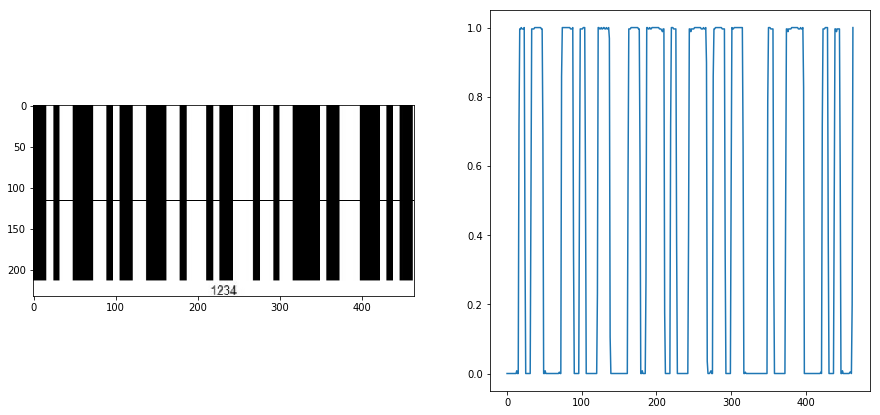

In [2]:
from scipy import fftpack, ndimage 
from skimage import color
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

img = plt.imread('images/barcode.png', 'uint8') # carrega a imagem

gray_im = color.rgb2gray(img) # converte para tons de cinza
fft2 = fftpack.fft2(gray_im) # utiliza função pronta para fft2
fft2_shifted = np.fft.fftshift(fft2)
fft2_scaled = 10*np.log10(abs(fft2_shifted)) # escala em dB para melhorar visualização


# configurações do print
print(type(img))
print(img.shape, img.dtype)

plt.figure(figsize=(15,7))
plt.subplot(122)
plt.plot(gray_im[116])
plt.subplot(121)
img_trace = gray_im
img_trace[116, :] = 0
plt.imshow(img_trace,cmap=plt.cm.gray)
plt.Line2D([0,0], [0,464], linewidth='10')


plt.show()

## Possível caminho para resolver o problema da rotação?
Transformada de Fourier 2D de um código de barras horizontal

<class 'numpy.ndarray'>
(232, 464, 4) uint8


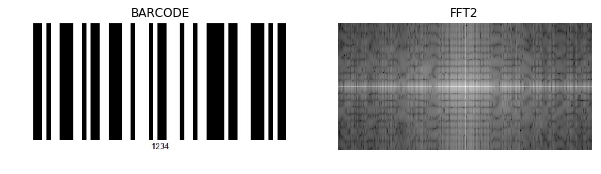

In [3]:
img = plt.imread('images/barcode.png', 'uint8') # carrega a imagem

gray_im = color.rgb2gray(img) # converte para tons de cinza
fft2 = fftpack.fft2(gray_im) # utiliza função pronta para fft2
fft2_shifted = np.fft.fftshift(fft2)
fft2_scaled = 10*np.log10(abs(fft2_shifted)) # escala em dB para melhorar visualização


# configurações do print
print(type(img))
print(img.shape, img.dtype)

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(img, cmap=plt.cm.gray)
plt.title('BARCODE')
plt.axis('off')
plt.subplot(122)
plt.imshow(fft2_scaled, cmap=plt.cm.gray) 
plt.title('FFT2')
plt.axis('off')



plt.show()

Transformada de Fourier 2D de um código de barras rotacionado

<class 'numpy.ndarray'>
(492, 492, 4) uint8


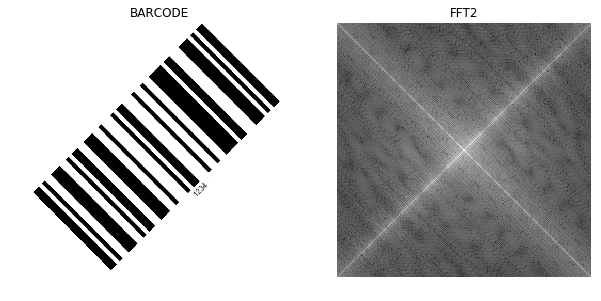

In [4]:
img = plt.imread('images/barcode-rotated.png', 'uint8') # carrega a imagem

gray_im = color.rgb2gray(img) # converte para tons de cinza
fft2 = fftpack.fft2(gray_im) # utiliza função pronta para fft2
fft2_shifted = np.fft.fftshift(fft2)
fft2_scaled = 10*np.log10(abs(fft2_shifted)) # escala em dB para melhorar visualização


# configurações do print
print(type(img))
print(img.shape, img.dtype)

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(img, cmap=plt.cm.gray)
plt.title('BARCODE')
plt.axis('off')
plt.subplot(122)
plt.imshow(fft2_scaled, cmap=plt.cm.gray) 
plt.title('FFT2')
plt.axis('off')
plt.show()

Uma possiblidade para corrigir a rotação é detectar a inclinação por meio da rotação do domínio de Fourier da imagem.

Assim, é necessário detectar as linhas que formam um X na na FFT2 e acessar sua inclinação.

Para isso, foi utilizada a transformada clássica de Hough para linhas retas

44.74860335195531

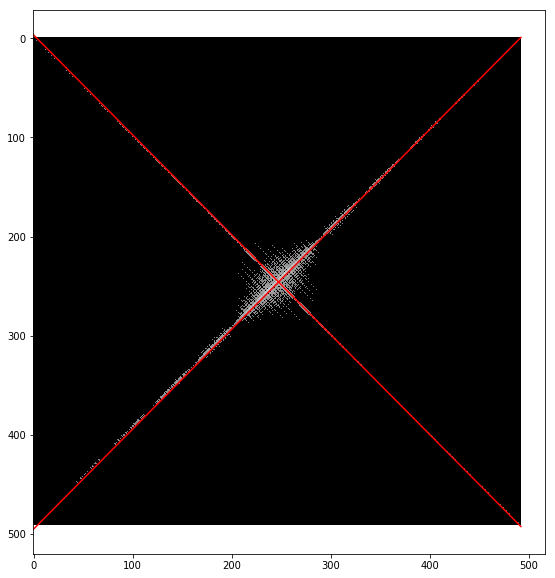

In [5]:
from skimage.transform import (hough_line, hough_line_peaks)
from skimage.transform import rotate

# Classic straight-line Hough transform
image = 10*np.log10(abs(fft2_shifted))
image[image < 0.5*np.max(image)] = 0
h, theta, d = hough_line(image)



plt.figure(figsize=(10,10))
plt.imshow(image, cmap=plt.cm.gray)
for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - image.shape[1] * np.cos(angle)) / np.sin(angle)
    plt.plot((0, image.shape[1]), (y0, y1), '-r')
    
_, angle, dist = hough_line_peaks(h, theta, d)

import math

angled = math.degrees(angle[0])

angled


Uma vez detectada a inclinação das retas que formam um X, aplica-se a rotação inversa na imagem para tê-la horizontal novamente

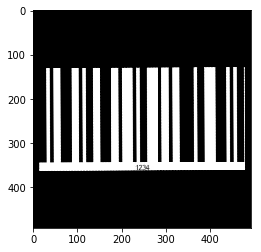

In [6]:
untilted = rotate(gray_im, -angled, clip=True)
plt.imshow(untilted, cmap=plt.cm.gray)